# Determining Population Densities and Intramicellar Distributions by Contrast Variation SANS

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve with soft ball P(Q) in J. Chem. Phys. 153, 184902 (2020)
# Calculate polymer distribution by contrast variation
#
# tensorflow 2.6.0

## Setup

Ensure you have installed these packages first  
``$ pip install tensorflow-probabilit``  
``$ pip install imageio``  
``$ pip install git+https://github.com/tensorflow/docs``  

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

## Define functions

### Load data

In [3]:
def is_header(x):
    n_header = 5
    return x>=n_header

In [4]:
def loaddata(filename):
    filename = data_path + 'S2_{:03d}.ABS'.format(contrast)
    with open(filename,'r') as fp:
        lines = fp.readlines()

    index_all = range(len(lines))
    index = list(filter(is_header, index_all))
    
    lines_data = list(itemgetter(*index)(lines))
    
    data_dict = {}
    for j, ld in enumerate(lines_data):
        raw_fields = struct_unpacker(ld.encode())
        ld_unpacked = {}
        for i in field_indices:
            fieldspec = fieldspecs[i]
            fieldname = fieldspec[iname]
            cast = fieldspec[itype]
            value = cast(raw_fields[i].decode().strip())
            ld_unpacked[fieldname] = [value]
        if j==0:
            data_dict = ld_unpacked
            continue
        data_dict = {key: [*data_dict[key], *ld_unpacked[key]] for key in data_dict}
    
    return data_dict

In [5]:
def get_struct_unpacker(fieldspecs, istart, iwidth):
    # https://gist.github.com/rochacbruno/059e1223f5b69d3b99b509a4962cf3aa
    """
    Build the format string for struct.unpack to use, based on the fieldspecs.
    fieldspecs is a list of [name, start, width] arrays.
    Returns a string like "6s2s3s7x7s4x9s".
    """
    unpack_len = 0
    unpack_fmt = ""
    for fieldspec in fieldspecs:
        start = fieldspec[istart] - 1
        end = start + fieldspec[iwidth]
        if start > unpack_len:
            unpack_fmt += str(start - unpack_len) + "x"
        unpack_fmt += str(end - start) + "s"
        unpack_len = end
    struct_unpacker = struct.Struct(unpack_fmt).unpack_from
    return struct_unpacker

In [6]:
from operator import itemgetter
import struct

fieldspecs = [
    # Name, Start, Width, Type
    ["Q (1/A)", 8, 8, float],
    ["I(Q) (1/cm)", 26, 6, float],
    ["std. dev. I(Q) (1/cm)", 40, 8, float],
    ["sigmaQ", 55, 9, float],
    ["meanQ", 72, 8, float],
    ["ShadowFactor", 95, 1, int]
]

iname, istart, iwidth, itype = 0, 1, 2, 3  # field indexes

fieldspecs.sort(key=itemgetter(istart))
struct_unpacker = get_struct_unpacker(fieldspecs, istart, iwidth)
field_indices = range(len(fieldspecs))

### Fit curve

In [7]:
def softball_Q(Q, fp):
    R1, R2, sigma1, sigma2, rc = fp[2:7]
    j1 = lambda QR: (tf.math.sin(QR)-QR*tf.math.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*tf.math.exp(-(Qsigma/2)**2)/QR
    
    QR1 = Q*R1
    QR2 = Q*R2
    Qsigma1 = Q*sigma1
    Qsigma2 = Q*sigma2
    
    P = (rc*F1(QR1,Qsigma1) + (1-rc)*F1(QR2,Qsigma2))**2
    
    return P

In [8]:
def softball_r(Q, fp, r = (np.arange(100)+1)):
    R1, R2, sigma1, sigma2, rc = fp[2:7]
    from scipy.special import erf   
    Deltarho1 = lambda r, R, sigma: 3/(8*np.pi*R**3)*(erf((r+R)/sigma)-erf((r-R)/sigma)
                                    +(np.exp(-((r+R)/sigma)**2)-np.exp(-((r-R)/sigma)**2))/(np.sqrt(np.pi)*r)
                                    )
    
    Deltarho_m = -(rc*Deltarho1(r, R1, sigma1) + (1-rc)*Deltarho1(r, R2, sigma2))
        
    return Deltarho_m

In [9]:
def fit_loss(fp, Q, IQ, IQ_err):
    P = softball_Q(Q, fp)
    IQ_th = fp[0]*P + fp[1]
    
    # mean-square error
    IQ_th_log = tf.math.log(IQ_th)
    IQ_log = tf.math.log(IQ)
    index = (Q>0.02)&(Q<0.5)
    err = tf.reduce_mean((IQ_th_log[index]-IQ_log[index])**2)
    
    d_IQ = tf.reduce_max(IQ_log[index])-tf.reduce_min(IQ_log[index])
    err_r = err/d_IQ
    
    return err_r

In [10]:
@tf.function
def train_step(fp, Q, IQ, IQ_err, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = fit_loss(fp, Q, IQ, IQ_err)
    gradients = tape.gradient(loss, fp)
    optimizer.apply_gradients(zip(gradients, fp))

In [11]:
def initialize():
    # tf.constant("Initial Guess")
    i_A = tf.constant(1.5)
    i_B = tf.constant(0.04)
    i_R1 = tf.constant(24.83)
    i_R2 = tf.constant(59.79)
    i_sigma1 = tf.constant(14.84)
    i_sigma2 = tf.constant(19.80)
    i_rc = tf.constant(0.4)
    
    # constraint=lambda t: tf.clip_by_value(t, "Lower Bound", "Upper Bound")
    A = tf.Variable(i_A, name='A', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 2))
    B = tf.Variable(i_B, name='B', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 1))
    R1 = tf.Variable(i_R1, name='R1', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, R2))
    R2 = tf.Variable(i_R2, name='R2', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, R1, 100))
    sigma1 = tf.Variable(i_sigma1, name='sigma1', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 10, 20))
    sigma2 = tf.Variable(i_sigma2, name='sigma2', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 10, 50))
    rc = tf.Variable(i_rc, name='rc', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 1))
    
    fp_i = [A, B, R1, R2, sigma1, sigma2, rc]
    return fp_i

### Generate image

In [12]:
def generate_image_Q(ax, filename, fp, Q, IQ, IQ_err, counter):
    P = softball_Q(Q, fp)
    IQ_th = fp[0]*P + fp[1]
    loss = fit_loss(fp, Q, IQ, IQ_err)
       
    ax[0].clear()
    
    ax[0].errorbar(Q, IQ, yerr=IQ_err, fmt=',k', elinewidth=1, capsize=2)
    ax[0].plot(Q, IQ_th, 'b')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    
    ax[0].set_xlim(0.02, 0.5)
    ax[0].set_ylim(0.02, 2)
    
    ax[0].text(0.05,0.12,'A = {:0.4f}, B = {:0.4f}, R1 = {:0.4f}, R2 = {:0.4f}'
             .format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy(),fp[3].numpy())
             ,transform=ax[0].transAxes)
    ax[0].text(0.05,0.06,'sigma1 = {:0.4f}, sigma2 = {:0.4f}, rc = {:0.4f}'
             .format(fp[4].numpy(),fp[5].numpy(),fp[6].numpy())
             ,transform=ax[0].transAxes)
    ax[0].text(0.80,0.95,'loss = {:0.4f}'
             .format(loss.numpy())
             ,transform=ax[0].transAxes)
    
    ax[0].set_xlabel('$Q$')
    ax[0].set_ylabel('$I(Q)$')
    
    fig.canvas.draw()
    #time.sleep(0.01)

In [13]:
def generate_image_r(ax, filename, fp, Q, IQ, IQ_err, counter):
    r = (np.arange(1000)+1)/10
    Deltarho_m = softball_r(Q, fp, r)
    Deltarho_h = softball_r(Q, [fp[0],fp[1],fp[2],fp[3],0.0,0.0,fp[6]], r)
    
    ax[1].clear()
    
    ax[1].plot(r, Deltarho_m, 'b')
    ax[1].plot(r, Deltarho_h, '--k')
    
    #ax[1].set_xscale('log')
    #ax[1].set_yscale('log')
    
    ax[1].set_xlim(0, 100)
    #ax[1].set_ylim(0.02, 2)
    
    ax[1].set_xlabel(r'$r$')
    ax[1].set_ylabel(r'$\Delta\rho_m(r)$')
        
    fig.canvas.draw()
    #time.sleep(0.01)

In [14]:
def generate_gif():
    anim_file = './figures/fit_{:03d}.gif'.format(contrast)
    
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('./figures/fit_{:03d}_*.png'.format(contrast))
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

-----

## Fit I(Q)

In [15]:
%matplotlib notebook

loaded ../data/S2/S2_080.ABS


<IPython.core.display.Javascript object>


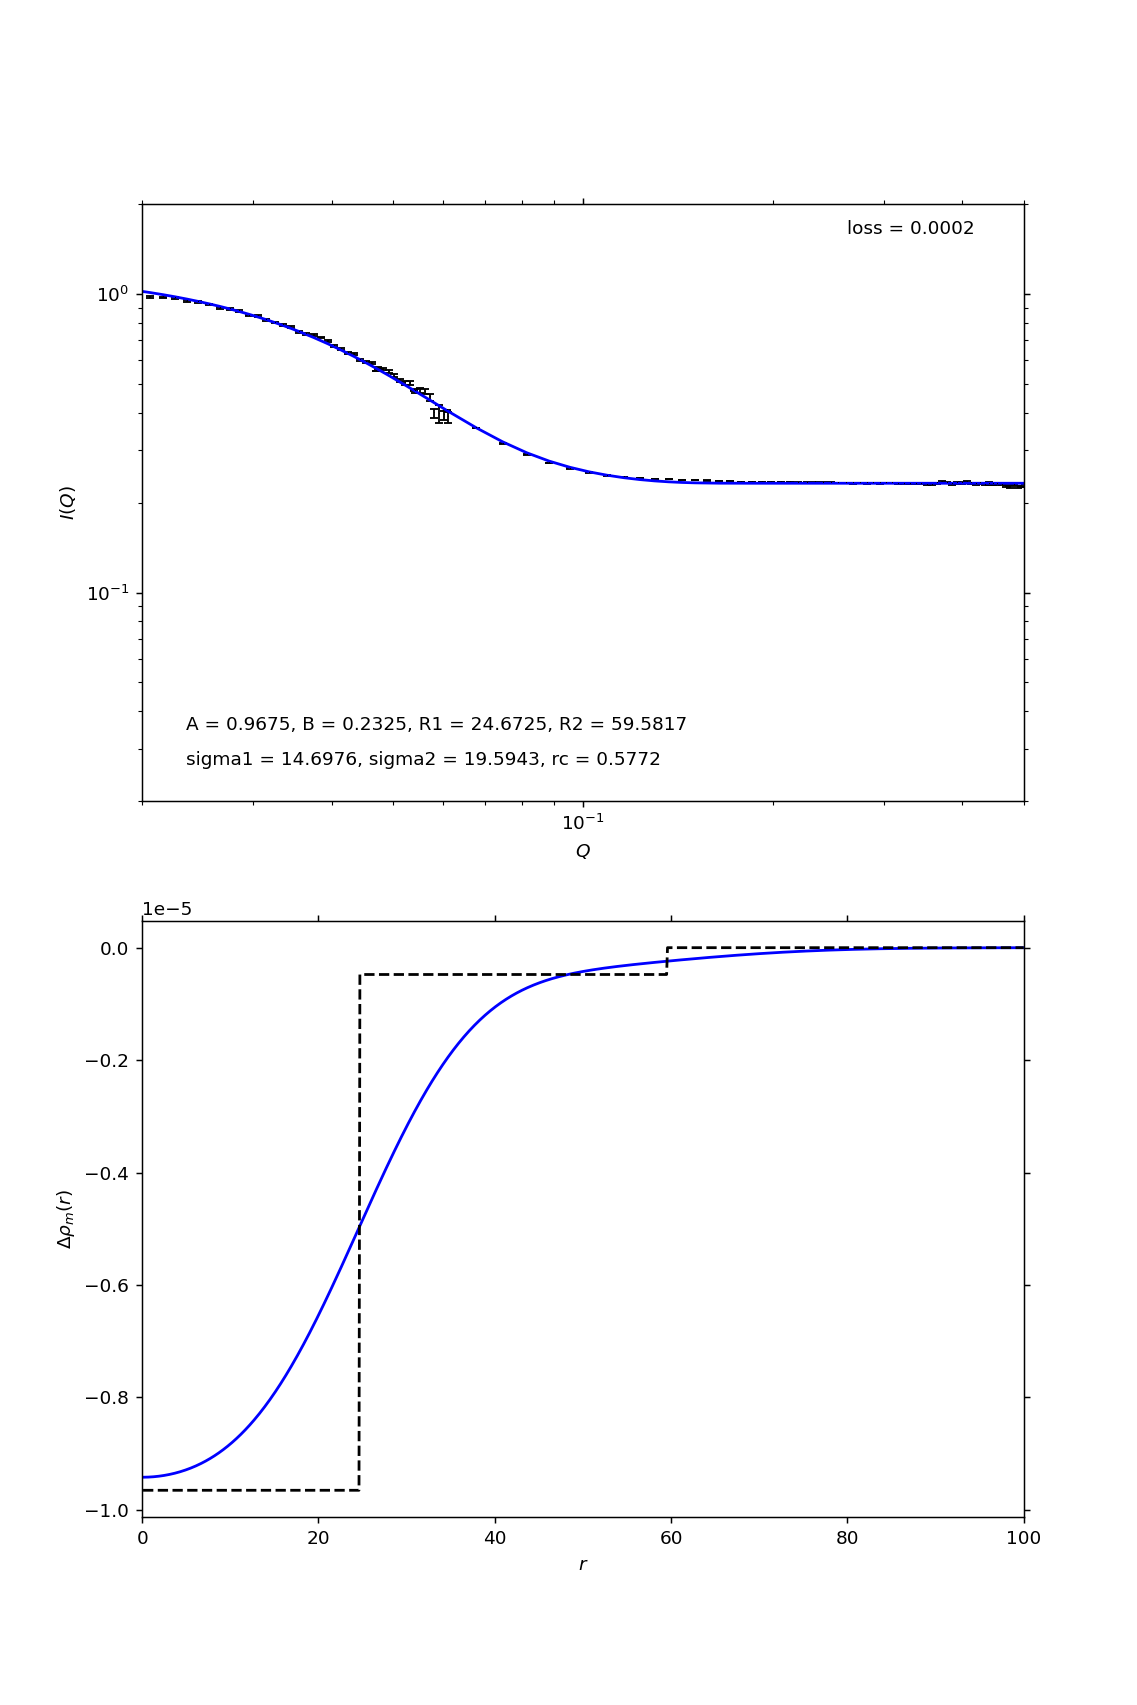

In [16]:
data_path = '../data/S2/'
contrasts = np.array([100, 95, 90, 85, 80, 75])

for i, contrast in enumerate(contrasts[4:5]):
    # Load data
    filename = data_path + 'S2_{:03d}.ABS'.format(contrast)
    data_dict = loaddata(filename)
    print('loaded '+ filename)
    
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_err = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)
    
    # Fit
    fp = initialize()
    loss = fit_loss(fp, Q, IQ, IQ_err)
    optimizer = tf.keras.optimizers.Adam(0.01) # set train rate HERE
    
    max_iter = 1000 # set maxiter HERE
    counter = 0
    fig,ax = plt.subplots(2,1, figsize=[6.4, 9.6])
    generate_image_Q(ax, filename, fp, Q, IQ, IQ_err, counter)
    generate_image_r(ax, filename, fp, Q, IQ, IQ_err, counter)
    pngname = './figures/fit_{:03d}_{:04d}.png'
    plt.savefig(pngname.format(contrast,counter))
    
    while loss > 1e-4:
        try:
            counter += 1
            if counter>max_iter:
                break
            
            loss = fit_loss(fp, Q, IQ, IQ_err)
            train_step(fp, Q, IQ, IQ_err, optimizer)
            if counter%20==0:
                generate_image_Q(ax, filename, fp, Q, IQ, IQ_err, counter)
                generate_image_r(ax, filename, fp, Q, IQ, IQ_err, counter)
                pngname = './figures/fit_{:03d}_{:04d}.png'
                plt.savefig(pngname.format(contrast,counter))
                
        except KeyboardInterrupt:
            break
    generate_gif()
    

### Display animated GIF


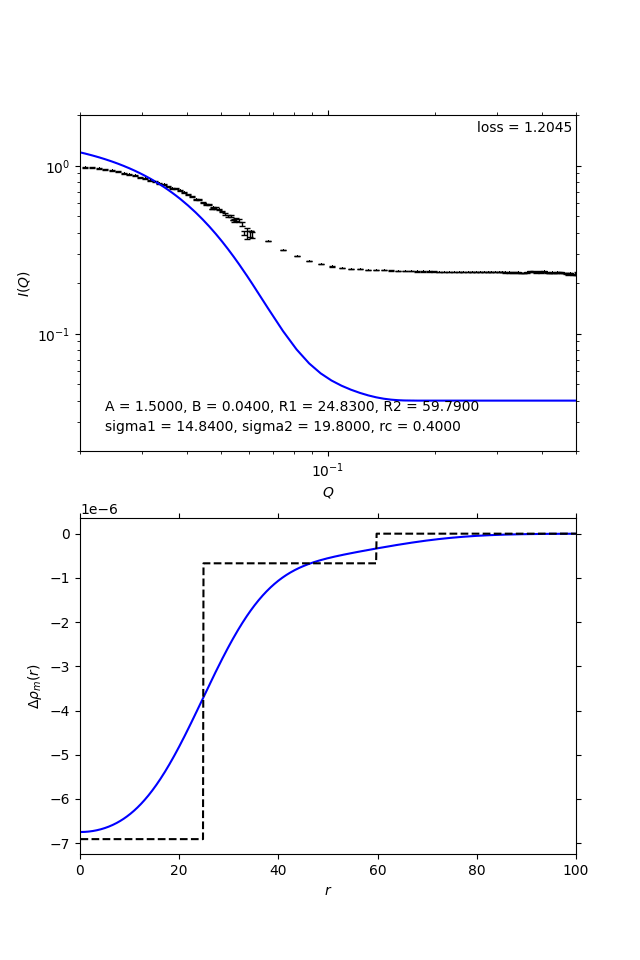

In [17]:
import tensorflow_docs.vis.embed as embed
anim_file = './figures/fit_{:03d}.gif'.format(contrast)
embed.embed_file(anim_file)

## Under construction

In [18]:
print('current fp: A = {:04f}, B = {:04f}, R1 = {:04f}, R2 = {:04f}, sigma1 = {:04f}, sigma2 = {:04f}, rc = {:04f}'
                  .format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy(),fp[3].numpy(),fp[4].numpy(),fp[5].numpy(),fp[6].numpy()))

current fp: A = 0.967471, B = 0.232453, R1 = 24.672497, R2 = 59.581715, sigma1 = 14.697554, sigma2 = 19.594315, rc = 0.577247
